In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def preprocess(imagefile_path):
   byte_img = tf.io.read_file(imagefile_path)
   img = tf.io.decode_jpeg(byte_img, channels=3)
   return img

In [3]:
images = tf.data.Dataset.list_files(os.path.join('data', '*.png'), shuffle=False)
images = images.map(preprocess)

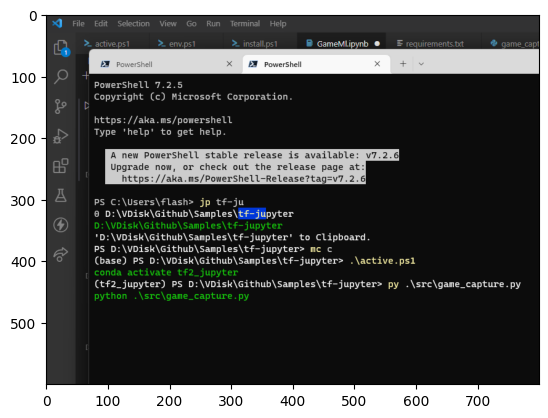

In [4]:
image1 = images.as_numpy_iterator().next()
#plt.imshow(preprocess(os.path.join('data', '6a650b96-1e34-11ed-a7d9-201e887f9b25.png')))
plt.imshow(image1)

In [5]:
def preprocess_keypress(file_path):
   keypress = tf.io.read_file(file_path)
   keys = tf.strings.split(keypress, '\r\n')
   if keys[0] == "None":
      return [0, 0, 0, 0]
   return [0, 0, 0, 0]

keypresses = tf.data.Dataset.list_files(os.path.join('data', '*.txt'), shuffle=False)
keypresses = keypresses.map(lambda x: tf.py_function(preprocess_keypress, [x], 
   [tf.int16, tf.int16, tf.int16, tf.int16]))   

In [6]:
def warp_array(x1,x2,x3,x4):
   return tf.expand_dims([x1,x2,x3,x4], axis=0)
keypresses = keypresses.map(warp_array)

In [7]:
for x in keypresses.as_numpy_iterator():
   print(x)

[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]


In [8]:
dataset = tf.data.Dataset.zip((images, keypresses))
dataset_len = len(dataset)
batch_size = 8
if batch_size > dataset_len:
   batch_size = dataset_len
prefetch_len = dataset_len // batch_size

In [9]:
dataset = dataset.cache()
dataset = dataset.shuffle(dataset_len)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(prefetch_len)

In [21]:
def unpack_y(x, y):
   # 消除 y 的dim
   return x, tf.squeeze(y, axis=1)
dataset = dataset.map(unpack_y)

In [22]:
x, y = dataset.as_numpy_iterator().next()
len(y)

8

In [23]:
y

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int16)

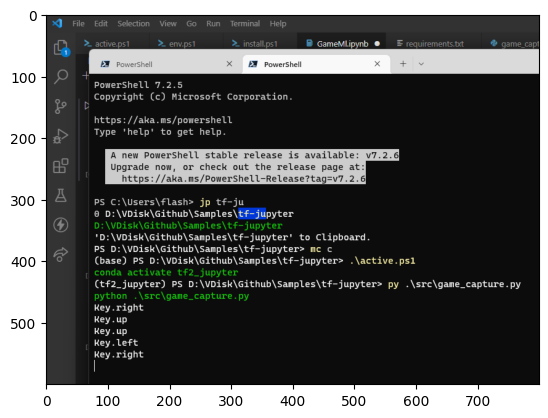

In [12]:
plt.imshow(x[0])

In [24]:
width, height, channels = images.as_numpy_iterator().next().shape
print(width, height, channels)


600 800 3


Do Deep Learning Model

In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D, Dropout, BatchNormalization


In [25]:
from statistics import mode

model = Sequential()
# images.as_numpy_iterator().next().shape 得到 (800,)
model.add(Conv2D(64, 5, strides=(3,3), activation='relu', input_shape=(width, height, channels)))
model.add(Conv2D(128, 4, strides=(3,3), activation='relu'))
model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# keypresses.as_numpy_iterator().next()[0].shape 得到 (4,)
model.add(Dense(4, activation='softmax'))
model.summary()


# 假如出現, 表示 model 耗用太多 memory
# OOM when allocating tensor with shape[60191872,128] and type float 


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 199, 266, 64)      4864      
                                                                 
 conv2d_7 (Conv2D)           (None, 66, 88, 128)       131200    
                                                                 
 flatten_3 (Flatten)         (None, 743424)            0         
                                                                 
 dense_4 (Dense)             (None, 4)                 2973700   
                                                                 
Total params: 3,109,764
Trainable params: 3,109,764
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile('adam', tf.losses.CategoricalCrossentropy())

In [27]:
model.fit(x, y, epochs=1)

1/1 [==============================] - 18s 18s/step - loss: 0.0000e+00
